## LARRY

Modified from the Klein lab and repurposed for the TrackerSeq pipeline. 
See [here](https://github.com/AllonKleinLab/LARRY).

In [1]:
import numpy as np, matplotlib.pyplot as plt, networkx as nx, pickle, json, gzip
%matplotlib inline
import pandas as pd
import itertools

## Set parameters

N_READS: Cutoff for the min number of reads supporting a given UMI/GFP-BC pair in a particular cell

N_UMIS: Cutoff for the min number of UMIs supporting a given cell/GFP-BC pair

N_HAMMING: Cutoff for the max hamming distance to collapse two GFP-BCs

CELL_BCS_PATH: Path to a .txt file with one cell-BC per line, corresponding to rows of the gene expression counts matrix

LIB_NAMES_PATH: Path to a .txt file with one library name per line, corresponding to rows of the gene expression counts matrix



In [2]:
N_READS = 10
N_UMIS = 6
N_HAMMING = 3
CELL_BCS_PATH = "/datastore_share/Users/mayho/cloneseq/MUC28072/cellbc_MUC28072.txt"
LIB_NAMES_PATH = '/datastore_share/Users/mayho/cloneseq/MUC28072/MUC28072_lib.txt'

## Read input files

In [3]:
cell_bcs = open(CELL_BCS_PATH).read().strip('\n').split('\n')
lib_names = open(LIB_NAMES_PATH).read().strip('\n').split('\n')

In [4]:
len(cell_bcs)

19156

## Load data and count reads

Read in the output of step 1 (LARRY_sorting_and_filtering.py) and count the number of reads supporting each (Sample, Cell-BC, UMI, GFP-BC) combination

In [5]:
counts = {}
f = open("/datastore_share/Users/mayho/cloneseq/MUC28072/MUC28072_extracted_reformat.fastq")
l = f.readline().strip('\n')
current_tag = []
i = 0
print('Reading in all barcodes')
while not (l == '' and len(current_tag)==0):
    i += 1
    if i % (3*10**6)==0: print('Processed '+repr(int(i/3))+' reads')
    if l == '':
        current_tag = []
    elif l[0] == '>':
        current_tag = l[1:].split(',')
    elif l != '' and len(current_tag)==3:
        current_tag.append(l)
        current_tag = tuple(current_tag)
        if not current_tag in counts: counts[current_tag] = 0
        counts[current_tag] += 1
        
    l = f.readline().strip('\n')

Reading in all barcodes
Processed 1000000 reads
Processed 2000000 reads
Processed 3000000 reads
Processed 4000000 reads
Processed 5000000 reads
Processed 6000000 reads
Processed 7000000 reads
Processed 8000000 reads
Processed 9000000 reads
Processed 10000000 reads
Processed 11000000 reads
Processed 12000000 reads
Processed 13000000 reads
Processed 14000000 reads
Processed 15000000 reads
Processed 16000000 reads


## Filter by number of reads
Continue with analysis with (Sample, Cell-BC, UMI, GFP-BC) combinations supported by at least N_READS reads

Retaining 334783 out of 12189883 (Sample,Cell-BC,UMI,GFP-BC) combinations


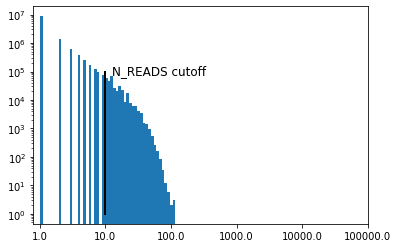

In [6]:
num_reads = [v for k,v in counts.items()]
plt.hist(np.log(num_reads)/np.log(10), bins=50)
plt.plot([np.log(N_READS)/np.log(10),np.log(N_READS)/np.log(N_READS)],[1,10**5],'-k',linewidth=2)
plt.xticks(range(6),np.logspace(0,5,6))
plt.text(np.log(N_READS)/np.log(10)*1.1,10**5*.8,'N_READS cutoff', fontsize=12)
plt.yscale('log')

counts_filtered = {k:v for k,v in counts.items() if v >= N_READS}
print('Retaining '+repr(len(counts_filtered))+ ' out of '+repr(len(counts))+' (Sample,Cell-BC,UMI,GFP-BC) combinations')

## Collapse GFP-BCs by hamming distance

In [7]:
def hamming(bc1,bc2): return np.sum([x1 != x2 for x1,x2 in zip(bc1,bc2)])

all_gfp_bcs = sorted(set([k[3] for k in counts_filtered]))
good_gfp_bcs = []
bc_map = {}
for i,bc1 in enumerate(all_gfp_bcs):
    if i > 0 and i % 500 == 0: print('Mapped '+repr(i)+' out of '+repr(len(all_gfp_bcs))+' barcodes')
    mapped = False
    for bc2 in good_gfp_bcs:
        if hamming(bc1,bc2) <= N_HAMMING:
            mapped = True
            bc_map[bc1] = bc2
            break
    if not mapped:
        good_gfp_bcs.append(bc1)

print('\nCollapsed '+repr(len(bc_map))+' barcodes')
for bc in good_gfp_bcs: bc_map[bc] = bc

Mapped 500 out of 27061 barcodes
Mapped 1000 out of 27061 barcodes
Mapped 1500 out of 27061 barcodes
Mapped 2000 out of 27061 barcodes
Mapped 2500 out of 27061 barcodes
Mapped 3000 out of 27061 barcodes
Mapped 3500 out of 27061 barcodes
Mapped 4000 out of 27061 barcodes
Mapped 4500 out of 27061 barcodes
Mapped 5000 out of 27061 barcodes
Mapped 5500 out of 27061 barcodes
Mapped 6000 out of 27061 barcodes
Mapped 6500 out of 27061 barcodes
Mapped 7000 out of 27061 barcodes
Mapped 7500 out of 27061 barcodes
Mapped 8000 out of 27061 barcodes
Mapped 8500 out of 27061 barcodes
Mapped 9000 out of 27061 barcodes
Mapped 9500 out of 27061 barcodes
Mapped 10000 out of 27061 barcodes
Mapped 10500 out of 27061 barcodes
Mapped 11000 out of 27061 barcodes
Mapped 11500 out of 27061 barcodes
Mapped 12000 out of 27061 barcodes
Mapped 12500 out of 27061 barcodes
Mapped 13000 out of 27061 barcodes
Mapped 13500 out of 27061 barcodes
Mapped 14000 out of 27061 barcodes
Mapped 14500 out of 27061 barcodes
Mappe

## Filter GFP-barcodes by UMI
Index (UMI, GFP-BC) combinations to cells, then filter out BCs supported by fewer than N_UMIS UMIs


Final annotation has 2616 clones in 2628 cells


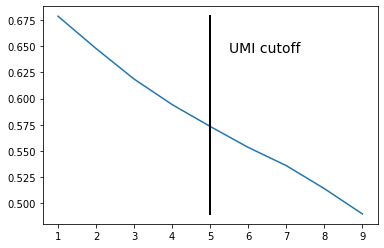

In [19]:
cell_data = {}
for lib,cell in zip(lib_names,cell_bcs):
    cell_data[(lib,cell)] = {}

for lib,cell,umi,BC in counts_filtered.keys():
    if (lib,cell) in cell_data:
        if not BC in cell_data[(lib,cell)]:
            cell_data[(lib,cell)][BC] = 0
        cell_data[(lib,cell)][BC] += 1

BC_lists = []
for i in range(1,10):
    BC_list = []
    for lib,cell in zip(lib_names,cell_bcs):
        bc_counts = cell_data[(lib,cell)]
        valid_bcs = [bc_map[k] for k,v in bc_counts.items() if v >= i]
        BC_list.append(''.join(sorted(valid_bcs)))
    BC_lists.append(BC_list)

efficiency = np.array([len([ll for ll in l if len(ll)>0]) for l in BC_lists]) / len(cell_bcs)
plt.plot(range(1,10),efficiency)
plt.plot([N_UMIS,N_UMIS],[np.min(efficiency),np.max(efficiency)],'-k',linewidth=2)
plt.text(N_UMIS*1.1,np.max(efficiency)*.95,'UMI cutoff',fontsize=14)

final_BCs = BC_lists[N_UMIS-1]
print('\nFinal annotation has '+repr(len(set(final_BCs)))+' clones in '+ repr(len([l for l in final_BCs if len(l)>0]))+' cells')

## Outout clonal anotations
There are three output files: 
- clone_mat.csv
- clone_mat.npy
- barcode_list.txt

The two clone_mat files store a binary matrix where rows are cells and columns are clones. A "1" at entry (i,j) indicates that cell i belongs to clone j. The barcode_list file stores the barcode for each cell. Two barcode strings separated by an underscore indicates that the cell contains multiple barcodes. An empty line implies no barcode for that cell.

In [8]:
BC_set = sorted(set([bc for bc in final_BCs if bc != '']))
clone_mat = np.zeros((len(final_BCs),len(BC_set)))
for i,bc in enumerate(final_BCs):
    if bc != '':
        j = BC_set.index(bc)
        clone_mat[i,j] = 1
clone_mat = np.array(clone_mat,dtype=int)
np.savetxt('/datastore_share/Users/mayho/crispr/ED210204/ED210204_matrix.csv',clone_mat,delimiter=',',fmt='%i');
np.save('/datastore_share/Users/mayho/crispr/ED210204/ED210204_matrix.npy',clone_mat);
open('/datastore_share/Users/mayho/crispr/ED210204/ED210204_barcode.txt','w').write('\n'.join(final_BCs));

### Explore ouput of clonal dataset

In [35]:
clone_mat = np.load('/datastore_share/Users/mayho/cloneseq/MUC28072/MUC28072_matrix.npy')

In [36]:
clone_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
# how many columns (barcodes) have labeled 2 or more cells
multi_cc = np.sum(clone_mat, axis = 0)
sum(1 for i in multi_cc if i >= 2)

1043

In [38]:
# how cells have more than one barcode
multi_bc = np.sum(clone_mat, axis = 1)
sum(1 for i in multi_bc if i >= 2)

1806

In [39]:
# how many columns(barcodes) have labeled 5 or more cells
sum(1 for i in multi_cc if i >= 5)

14

In [113]:
clone_mat = pd.read_csv('/data/mayerlab/mayho/clonal_analysis/raw_files/CS200528/spike_mat.csv')

In [114]:
clone_mat.shape

(56914, 6200)

In [115]:
# how many columns (barcodes) have labeled 2 or more cells
multi_cc = np.sum(clone_mat, axis = 0)
sum(1 for i in multi_cc if i >= 2)

2005

In [206]:
# how many columns(barcodes) have labeled 5 or more cells
sum(1 for i in multi_cc if i >= 3)

7

In [35]:
# if cells are labeled by more than one barcode
multi_bc = np.sum(clone_mat, axis = 1)
sum(1 for i in multi_bc if i == 1)

7748

In [96]:
# how many cells are unlabeled
sum(1 for i in multi_bc if i == 0 )

1393

In [97]:
# how many are single cell clones
sum(1 for i in multi_bc if i == 1 )

11683

### Script to call multiple BCs

**Filter by UMI**

I added a comma to separate cells with multiple BCs


Final annotation has 2616 clones in 2628 cells


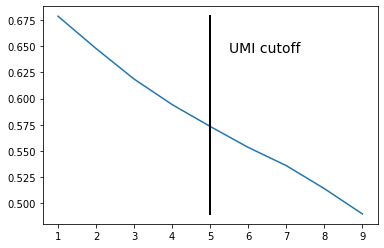

In [14]:
cell_data = {}
for lib,cell in zip(lib_names,cell_bcs):
    cell_data[(lib,cell)] = {}

for lib,cell,umi,BC in counts_filtered.keys():
    if (lib,cell) in cell_data:
        if not BC in cell_data[(lib,cell)]:
            cell_data[(lib,cell)][BC] = 0
        cell_data[(lib,cell)][BC] += 1

BC_lists = []
for i in range(1,10):
    BC_list = []
    for lib,cell in zip(lib_names,cell_bcs):
        bc_counts = cell_data[(lib,cell)]
        valid_bcs = [bc_map[k] for k,v in bc_counts.items() if v >= i]
        BC_list.append(','.join(sorted(valid_bcs))) # added a comma to separate multiple-barcode 
    BC_lists.append(BC_list)

efficiency = np.array([len([ll for ll in l if len(ll)>0]) for l in BC_lists]) / len(cell_bcs)
plt.plot(range(1,10),efficiency)
plt.plot([N_UMIS,N_UMIS],[np.min(efficiency),np.max(efficiency)],'-k',linewidth=2)
plt.text(N_UMIS*1.1,np.max(efficiency)*.95,'UMI cutoff',fontsize=14)

final_BCs = BC_lists[N_UMIS-1]
print('\nFinal annotation has '+repr(len(set(final_BCs)))+' clones in '+ repr(len([l for l in final_BCs if len(l)>0]))+' cells')

**Reading out file**

A number of key modifications were made. Multiple barcodes that were considered as one are split into multiple strings so that each column in output csv and npy file is one barcode rather than multiple bcs.

In [15]:
BC_set = sorted(set([bc for bc in final_BCs if bc != '']))
BC_set = list(map(lambda x: x.split(','), BC_set))
BC_set = list(itertools.chain.from_iterable(BC_set))
clone_mat = np.zeros((len(final_BCs),len(BC_set)))
for i,bc in enumerate(final_BCs):
    if bc != '':
        multi_bc = bc.split(',')
        for n in range(len(multi_bc)):
            j = BC_set.index(multi_bc[n])
            clone_mat[i,j] = 1
clone_mat = np.array(clone_mat,dtype=int)
np.savetxt('/datastore_share/Users/mayho/cloneseq/MUC28071/MUC28071_matrix_UMI5_test.csv',clone_mat,delimiter=',',fmt='%i');
np.save('/datastore_share/Users/mayho/cloneseq/MUC28071/MUC28071_matrix_UMI5_test.npy',clone_mat);
open('/datastore_share/Users/mayho/cloneseq/MUC28071/MUC28071_barcode_UMI5_test.txt','w').write('\n'.join(final_BCs));